<a href="https://colab.research.google.com/github/rurusasu/RecommendSystem/blob/main/IntTowerResidualRecommendModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 自作データセットで TowTowerRecommendModel を試験する
参考:
* [1つの Two-Tower モデルで4種類の推薦を実現する](https://qiita.com/rayuron/items/cc04468de7af3d82bac2)
* [Two-Tower Recommendationについて](https://qiita.com/akira_saigo/items/fb07c970febc872d22e3)

データセット: MovieLens-100k

In [1]:
# Googleドライブのマウント
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
base_dir = "/content/drive/MyDrive/Google AI Studio"

In [3]:
!pip install  --upgrade -q tensorflow_recommenders tensorflow-datasets apache-beam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.0/152.0 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 669.1/669.1 kB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.0/252.0 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 56.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 47.7 MB/s e

In [6]:
import re
import os
import tempfile
from typing import List, Dict, Union, Tuple
import json
import pickle

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.style.use("seaborn-whitegrid")

<ipython-input-6-00ca7f9ea516>:18: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


# データセットの読み出しと前処理

In [7]:
# エクセルファイルからデータを読み込む
#data = pd.read_excel(f"{base_dir}/old/sample_merged_full.xlsx")
#data = pd.read_excel(f"{base_dir}/merged_full.xlsx")

with open(f"{base_dir}/sample_merged_full_10k.pkl", "rb") as f:
    data = pickle.load(f)

data.head(2)

,user_id,target_id,rating,user_name_target,nickname_target,gender_target,location_target,age_range_target,height_range_target,body_type_target,...,body_type_user,personality_user,appearance_user,job_user,blood_type_user,car_user,interests_user,salary_user,plan_user,account_creation_timestamp_user
0,1,8627,0,原田遥,アオイ,女性,埼玉県伊奈町,45-49,150-154,普通,...,スリム,元気,セクシー系,会社員,O型,有り,技術・プログラミング,8160000,option2,2024-01-14 00:11:34
1,1,18213,0,井上萌,ユイ,女性,福島県玉川村,30-34,150-154,スリム,...,スリム,元気,セクシー系,会社員,O型,有り,技術・プログラミング,8160000,option2,2024-01-14 00:11:34


In [8]:
from tensorflow.keras.utils import to_categorical

# ラベルに不正な値が含まれている可能性があるので、削除
cleaning_data = data[data['rating'].isin([0, 1, 2])]
cleaning_data = cleaning_data.dropna()

# 不要なカラムの削除
cleaning_data = cleaning_data.drop(columns=['user_id', 'target_id', 'user_name_target', 'nickname_target',
                     'plan_target', 'account_creation_timestamp_target',
                     'user_name_user', 'nickname_user', 'plan_user',
                     'account_creation_timestamp_user'])

# 特徴量とラベルの分離
features = cleaning_data.drop(columns=['rating'])
labels = cleaning_data['rating']
# ラベルをOne-Hotエンコーディング
#labels = to_categorical(labels, num_classes=3)

# データの確認
features.head(2)

,gender_target,location_target,age_range_target,height_range_target,body_type_target,personality_target,appearance_target,job_target,blood_type_target,car_target,...,age_range_user,height_range_user,body_type_user,personality_user,appearance_user,job_user,blood_type_user,car_user,interests_user,salary_user
0,女性,埼玉県伊奈町,45-49,150-154,普通,面白い,-,会社員,A型,無し,...,22-25,175-179,スリム,元気,セクシー系,会社員,O型,有り,技術・プログラミング,8160000
1,女性,福島県玉川村,30-34,150-154,スリム,明るい,セクシー系,会社員,A型,無し,...,22-25,175-179,スリム,元気,セクシー系,会社員,O型,有り,技術・プログラミング,8160000


In [9]:
print("features nan\n" + str(features.isna().sum()))
print(features.info())

features nan
gender_target          0
location_target        0
age_range_target       0
height_range_target    0
body_type_target       0
personality_target     0
appearance_target      0
job_target             0
blood_type_target      0
car_target             0
interests_target       0
salary_target          0
gender_user            0
location_user          0
age_range_user         0
height_range_user      0
body_type_user         0
personality_user       0
appearance_user        0
job_user               0
blood_type_user        0
car_user               0
interests_user         0
salary_user            0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108562 entries, 0 to 108561
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   gender_target        108562 non-null  object
 1   location_target      108562 non-null  object
 2   age_range_target     108562 non-null  object
 3   height_r

# モデル定義

## 付属クラス

In [10]:
class SparseFeat:
    def __init__(self, name, vocabulary_size, embedding_dim, dtype=tf.int32, use_hash=False):
        self.name = name
        self.vocabulary_size = vocabulary_size
        self.embedding_dim = embedding_dim
        self.dtype = dtype
        self.use_hash = use_hash

    def get_config(self):
        return {
            'name': self.name,
            'vocabulary_size': self.vocabulary_size,
            'embedding_dim': self.embedding_dim,
            'dtype': self.dtype.name,
            'use_hash': self.use_hash
        }

    @classmethod
    def from_config(cls, config):
        config['dtype'] = tf.dtypes.as_dtype(config.get('dtype', 'int32'))
        return cls(**config)

class DenseFeat:
    def __init__(self, name: str):
        self.name = name

    def get_config(self):
        return {'name': self.name}

    @classmethod
    def from_config(cls, config):
        return cls(**config)

class VarLenSparseFeat:
    def __init__(self, name: str, vocabulary_size: int, embedding_dim: int):
        self.name = name
        self.vocabulary_size = vocabulary_size
        self.embedding_dim = embedding_dim

    def get_config(self):
        return {
            'name': self.name,
            'vocabulary_size': self.vocabulary_size,
            'embedding_dim': self.embedding_dim
        }

    @classmethod
    def from_config(cls, config):
        return cls(**config)


## 付属関数

In [11]:
# Embedding辞書の作成
def create_embedding_dict(feature_columns: List[Union[SparseFeat, DenseFeat, VarLenSparseFeat]]) -> Dict[str, tf.keras.layers.Embedding]:
    embedding_dict = {}
    for feat in feature_columns:
        if isinstance(feat, SparseFeat) or isinstance(feat, VarLenSparseFeat):
            embedding_dict[feat.name] = tf.keras.layers.Embedding(feat.vocabulary_size, feat.embedding_dim)
    return embedding_dict

# 入力データから_userで終わる特徴のみを抽出
def filter_user_inputs(inputs: Dict[str, tf.Tensor]) -> Dict[str, tf.Tensor]:
    return {k: v for k, v in inputs.items() if k.endswith('_user')}

def create_sparse_embeddings(user_inputs: Dict[str, tf.Tensor], feature_columns: List[Union[SparseFeat, DenseFeat, VarLenSparseFeat]], embedding_dict: Dict[str, tf.keras.layers.Embedding]) -> Tuple[List[tf.Tensor], List[tf.Tensor]]:
    print("User Inputs:", user_inputs.keys())  # デバッグ用にuser_inputsのキーを表示
    print("Embedding Dict:", embedding_dict.keys())  # デバッグ用にembedding_dictのキーを表示

    sparse_feature_columns = list(filter(lambda x: isinstance(x, SparseFeat), feature_columns))
    dense_feature_columns = list(filter(lambda x: isinstance(x, DenseFeat), feature_columns))
    varlen_sparse_feature_columns = list(filter(lambda x: isinstance(x, VarLenSparseFeat), feature_columns))

    print("Sparse Feature Columns:", [feat.name for feat in sparse_feature_columns])  # デバッグ用出力
    print("Dense Feature Columns:", [feat.name for feat in dense_feature_columns])  # デバッグ用出力
    print("VarLen Sparse Feature Columns:", [feat.name for feat in varlen_sparse_feature_columns])  # デバッグ用出力

    sparse_embedding_list = [tf.reduce_mean(embedding_dict[feat.name](user_inputs[feat.name]), axis=1) if len(user_inputs[feat.name].shape) == 2 else embedding_dict[feat.name](user_inputs[feat.name]) for feat in sparse_feature_columns if feat.name in user_inputs]
    varlen_sparse_embedding_list = [tf.reduce_mean(embedding_dict[feat.name](user_inputs[feat.name]), axis=1) for feat in varlen_sparse_feature_columns if feat.name in user_inputs]
    dense_value_list = [user_inputs[feat.name] for feat in dense_feature_columns if feat.name in user_inputs]

    return sparse_embedding_list + varlen_sparse_embedding_list, dense_value_list



## 前処理クラス

In [12]:
# 前処理クラスの定義
class Preprocessor:
    def __init__(self, features: pd.DataFrame, embedding_dims: dict):
        self.embedding_dims = embedding_dims
        self.vocabularies = self.generate_vocabularies(features)
        self.lookup_layers = self.create_lookup_layers()

    def generate_vocabularies(self, features: pd.DataFrame) -> dict:
        vocabularies = {}
        for feature_name in self.embedding_dims:
            if features[feature_name].dtype == 'object' and not feature_name.startswith('interests_'):
                vocab = sorted(features[feature_name].dropna().unique())
                vocabularies[feature_name] = vocab
            elif feature_name.startswith('interests_'):
                all_interests = []
                for interests_str in features[feature_name].dropna():
                    all_interests.extend(re.split(r',\s*', interests_str))
                vocabularies[feature_name] = sorted(set(all_interests))
        return vocabularies

    def create_lookup_layers(self) -> dict:
        lookup_layers = {}
        for feature_name, vocab in self.vocabularies.items():
            if not feature_name.startswith('interests_'):
                lookup_layers[feature_name] = tf.keras.layers.StringLookup(vocabulary=vocab, mask_token=None, num_oov_indices=1, output_mode='int')
            else:
                lookup_layers[feature_name] = tf.keras.layers.StringLookup(vocabulary=vocab, mask_token=None, output_mode='multi_hot')
        return lookup_layers

    def process(self, data: pd.DataFrame) -> dict:
        processed_data = {}
        # NaNを含むレコードを削除
        data = data.dropna(subset=self.lookup_layers.keys())

        for feature_name, lookup_layer in self.lookup_layers.items():
            if feature_name.startswith('interests_'):
                # interests_userの分割
                interests_list = data[feature_name].apply(lambda x: re.split(r',\s*', x)).tolist()
                max_len = max(map(len, interests_list))
                interests_padded = [interests + [''] * (max_len - len(interests)) for interests in interests_list]
                indices = lookup_layer(interests_padded)
                processed_data[feature_name] = indices
            else:
                indices = lookup_layer(data[feature_name].astype(str).values)
                indices = tf.where(indices == 0, tf.zeros_like(indices), indices - 1)  # インデックスの範囲を修正
                processed_data[feature_name] = indices
                max_index = len(self.vocabularies[feature_name])
                if tf.reduce_any(processed_data[feature_name] >= max_index):
                    raise ValueError(f"Feature '{feature_name}' contains out-of-vocabulary index.")

        # salary_userおよびsalary_targetの特別な前処理
        for feature_name in ['salary_user', 'salary_target']:
            if feature_name in data.columns:
                processed_data[feature_name] = tf.convert_to_tensor(data[feature_name].values, dtype=tf.float32)

        return processed_data

    def create_feature_columns(self) -> List[Union[SparseFeat, DenseFeat, VarLenSparseFeat]]:
        feature_columns = []
        for feature_name, vocab in self.vocabularies.items():
            if feature_name.startswith('interests_'):
                feature_columns.append(VarLenSparseFeat(feature_name, vocabulary_size=len(vocab), embedding_dim=self.embedding_dims[feature_name]))
            else:
                feature_columns.append(SparseFeat(feature_name, vocabulary_size=len(vocab), embedding_dim=self.embedding_dims[feature_name]))
        for feature_name in self.embedding_dims:
            if feature_name not in self.vocabularies:
                feature_columns.append(DenseFeat(feature_name))
        return feature_columns

In [13]:
# Display the dimensions of processed data columns
#processed_data_dims = {k: v.shape for k, v in processed_data.items()}
#for key, value in processed_data_dims.items():
#    print(f"{key}: {value}")

### 前処理したデータのTensorをパディングして次元(列数)を合わせる

In [14]:
def equalize_data_shapes_auto(processed_data: dict) -> dict:
    # Find the maximum length and width
    max_len = max(v.shape[0] for v in processed_data.values())
    max_width = max(v.shape[1] if len(v.shape) > 1 else 1 for v in processed_data.values())

    for key, value in processed_data.items():
        if len(value.shape) == 1:
            # 1次元データの場合
            value = np.pad(value, (0, max_len - value.shape[0]), 'constant', constant_values=0)
            value = np.expand_dims(value, axis=1)
            value = np.pad(value, ((0, 0), (0, max_width - 1)), 'constant', constant_values=0)
        elif len(value.shape) == 2:
            # 2次元データの場合
            value = np.pad(value, ((0, max_len - value.shape[0]), (0, 0)), 'constant', constant_values=0)
            value = np.pad(value, ((0, 0), (0, max_width - value.shape[1])), 'constant', constant_values=0)
        processed_data[key] = value[:max_len, :max_width]

    return processed_data

# Equalize data shapes
#equalized_data = equalize_data_shapes_auto(processed_data)

In [15]:
# Display the dimensions of equalized data columns
#equalized_data_dims = {k: v.shape for k, v in equalized_data.items()}
#for key, value in equalized_data_dims.items():
#    print(f"{key}: {value}")

### 前処理したデータの各Tensorの平均値のみを使って1次元のTensorに変換

In [16]:
def replace_all_with_mean(processed_data: dict) -> dict:
    for key in processed_data.keys():
        # 各カラムのデータを取得
        target_data = processed_data[key]

        # データが2次元であることを確認
        if len(target_data.shape) == 2:
            # 各行の平均値を計算
            mean_values = np.mean(target_data, axis=1)

            # 1次元の形状に変換して置き換え
            processed_data[key] = mean_values

    return processed_data

#replaced_data = replace_all_with_mean(processed_data)

In [17]:
# Display the dimensions of equalized data columns
#replaced_data_dims = {k: v.shape for k, v in replaced_data.items()}
#for key, value in replaced_data_dims.items():
#    print(f"{key}: {value}")

### 前処理したデータをpandas DataFrameに変換

In [18]:
def tensors_to_dataframe(processed_data: dict) -> pd.DataFrame:
    df_dict = {}
    for key, tensor in processed_data.items():
        if isinstance(tensor, tf.Tensor):
            df_dict[key] = tensor.numpy()
        elif isinstance(tensor, np.ndarray):
            df_dict[key] = tensor
        else:
            raise ValueError(f"Unsupported data type for key {key}: {type(tensor)}")

    # Convert dictionary of numpy arrays to DataFrame
    # Flatten the arrays if they are more than 1D to match DataFrame structure
    for key, value in df_dict.items():
        if len(value.shape) > 1:
            df_dict[key] = [list(row) for row in value]
        else:
            df_dict[key] = value.tolist()

    df = pd.DataFrame(df_dict)
    return df

In [19]:
# Convert to DataFrame
#df = tensors_to_dataframe(replaced_data)
#print(df.head(2))

## レイヤー

### LightSE

In [20]:
# LightSEクラスの定義
class LightSE(tf.keras.Model):
    def __init__(self, field_size, embedding_size=32):
        super(LightSE, self).__init__()
        self.field_size = field_size
        self.embedding_size = embedding_size
        self.excitation = tf.keras.Sequential([
            tf.keras.layers.Dense(self.field_size, use_bias=False)
        ])
        self.softmax = tf.keras.layers.Softmax(axis=1)

    def call(self, inputs):
        if len(inputs.shape) != 3:
            raise ValueError(
                f"Unexpected inputs dimensions {len(inputs.shape)}, expect to be 3 dimensions")

        Z = tf.reduce_mean(inputs, axis=-1)
        A = self.excitation(Z)
        A = self.softmax(A)
        out = inputs * tf.expand_dims(A, axis=2)

        return inputs + out

    def get_config(self):
        config = super(LightSE, self).get_config()
        config.update({
            'field_size': self.field_size,
            'embedding_size': self.embedding_size
        })
        return config

### DNN

In [21]:
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, layer_size, activation='relu', use_bn=False, use_ln=False):
        super(ResidualBlock, self).__init__()
        self.layer_size = layer_size
        self.dense = tf.keras.layers.Dense(layer_size)
        self.activation = tf.keras.layers.Activation(activation)
        self.use_bn = use_bn
        self.use_ln = use_ln
        self.matching_dense = None

        if use_bn:
            self.bn = tf.keras.layers.BatchNormalization()
        if use_ln:
            self.ln = tf.keras.layers.LayerNormalization()

    def build(self, input_shape):
        input_dim = input_shape[-1]
        if self.layer_size != input_dim:
            self.matching_dense = tf.keras.layers.Dense(self.layer_size, activation=None)

    def call(self, inputs):
        x = self.dense(inputs)
        if self.use_bn:
            x = self.bn(x)
        if self.use_ln:
            x = self.ln(x)
        x = self.activation(x)

        if self.matching_dense:
            inputs = self.matching_dense(inputs)

        return self.activation(x + inputs)

    def get_config(self):
        config = super(ResidualBlock, self).get_config()
        config.update({
            'layer_size': self.layer_size,
            'activation': self.activation.__name__,
            'use_bn': self.use_bn,
            'use_ln': self.use_ln
        })
        return config

class DNN(tf.keras.Model):
    def __init__(self, layer_sizes: List[int], activation='relu', use_bn: bool = False, use_ln: bool = False):
        super(DNN, self).__init__()
        self.use_bn = use_bn
        self.use_ln = use_ln
        self.layer_sizes = layer_sizes
        self.activation = activation
        self.residual_blocks = []

        for layer_size in layer_sizes:
            self.residual_blocks.append(
                ResidualBlock(layer_size, activation, use_bn, use_ln)
            )

        self.output_layer = tf.keras.layers.Dense(1)

    def call(self, inputs):
        x = inputs
        for block in self.residual_blocks:
            x = block(x)
        return self.output_layer(x)

    def get_config(self):
        config = super(DNN, self).get_config()
        config.update({
            'layer_sizes': self.layer_sizes,
            'activation': self.activation,
            'use_bn': self.use_bn,
            'use_ln': self.use_ln
        })
        return config

## Models

### UserModel

In [22]:
# UserModelの定義
class UserModel(tf.keras.Model):
    def __init__(
            self,
            layer_sizes,
            field_size: int,
            embedding_size: int,
            embedding_dict: dict,
            feature_columns,
            activation: str='relu',
            use_bn: bool = False,
            use_ln: bool = False
        ):
        super().__init__()
        self.User_SE = LightSE(field_size=field_size, embedding_size=embedding_size)
        self.feature_columns = feature_columns
        self.embedding_dict = embedding_dict
        self.dnn = DNN(layer_sizes=layer_sizes, activation=activation, use_bn=use_bn, use_ln=use_ln)
        self.final_dense = tf.keras.layers.Dense(1)
        self.flatten = tf.keras.layers.Flatten()

    def call(self, inputs: dict) -> tf.Tensor:
        sparse_embeddings, dense_values = create_sparse_embeddings(inputs, self.feature_columns, self.embedding_dict)
        user_dnn_input = tf.concat(sparse_embeddings, axis=-1)
        User_sim_embedding = self.User_SE(tf.expand_dims(user_dnn_input, axis=1))
        sparse_dnn_input = self.flatten(User_sim_embedding)
        dense_values_flat = tf.concat([tf.expand_dims(d, axis=-1) if len(d.shape) == 1 else d for d in dense_values], axis=-1)
        user_dnn_input = tf.concat([sparse_dnn_input, dense_values_flat], axis=1)
        dnn_output = self.dnn(user_dnn_input)
        final_output = self.final_dense(dnn_output)
        return final_output

    def get_config(self):
        config = super(UserModel, self).get_config()
        config.update({
            'layer_sizes': self.dnn.layer_sizes,
            'field_size': self.User_SE.field_size,
            'embedding_size': self.User_SE.embedding_size,
            'embedding_dict': json.dumps({k: v.get_config() for k, v in self.embedding_dict.items()}),
            'feature_columns': json.dumps([feat.get_config() for feat in self.feature_columns]),
            'activation': self.dnn.activation,
            'use_bn': self.dnn.use_bn,
            'use_ln': self.dnn.use_ln
        })
        return config

    @classmethod
    def from_config(cls, config):
        embedding_dict_config = json.loads(config.pop('embedding_dict'))
        embedding_dict = {k: tf.keras.layers.Embedding.from_config(v) for k, v in embedding_dict_config.items()}
        feature_columns_config = json.loads(config.pop('feature_columns'))
        feature_columns = [SparseFeat.from_config(feat) if 'embedding_dim' in feat else DenseFeat.from_config(feat) for feat in feature_columns_config]
        return cls(embedding_dict=embedding_dict, feature_columns=feature_columns, **config)

### ItemModel

In [23]:
# ItemModelの定義
class ItemModel(tf.keras.Model):
    def __init__(
            self,
            layer_sizes,
            field_size: int,
            embedding_size: int,
            embedding_dict: dict,
            feature_columns,
            activation: str='relu',
            use_bn: bool = False,
            use_ln: bool = False
        ):
        super().__init__()
        self.Item_SE = LightSE(field_size=field_size, embedding_size=embedding_size)
        self.embedding_dict = embedding_dict
        self.feature_columns = feature_columns
        self.dnn = DNN(layer_sizes=layer_sizes, activation=activation, use_bn=use_bn, use_ln=use_ln)
        self.final_dense = tf.keras.layers.Dense(1)
        self.flatten = tf.keras.layers.Flatten()

    def call(self, inputs: dict) -> tf.Tensor:
        sparse_embeddings, dense_values = create_sparse_embeddings(inputs, self.feature_columns, self.embedding_dict)
        item_dnn_input = tf.concat(sparse_embeddings, axis=-1)
        Item_sim_embedding = self.Item_SE(tf.expand_dims(item_dnn_input, axis=1))
        sparse_dnn_input = self.flatten(Item_sim_embedding)
        dense_values_flat = tf.concat([tf.expand_dims(d, axis=-1) if len(d.shape) == 1 else d for d in dense_values], axis=-1)
        item_input = tf.concat([sparse_dnn_input, dense_values_flat], axis=1)
        dnn_output = self.dnn(item_input)
        final_output = self.final_dense(dnn_output)
        return final_output

    def get_config(self):
        config = super(ItemModel, self).get_config()
        config.update({
            'layer_sizes': self.dnn.layer_sizes,
            'field_size': self.Item_SE.field_size,
            'embedding_size': self.Item_SE.embedding_size,
            'embedding_dict': json.dumps({k: v.get_config() for k, v in self.embedding_dict.items()}),
            'feature_columns': json.dumps([feat.get_config() for feat in self.feature_columns]),
            'activation': self.dnn.activation,
            'use_bn': self.dnn.use_bn,
            'use_ln': self.dnn.use_ln
        })
        return config

    @classmethod
    def from_config(cls, config):
        embedding_dict_config = json.loads(config.pop('embedding_dict'))
        embedding_dict = {k: tf.keras.layers.Embedding.from_config(v) for k, v in embedding_dict_config.items()}
        feature_columns_config = json.loads(config.pop('feature_columns'))
        feature_columns = [SparseFeat.from_config(feat) if 'embedding_dim' in feat else DenseFeat.from_config(feat) for feat in feature_columns_config]
        return cls(embedding_dict=embedding_dict, feature_columns=feature_columns, **config)

### TowTowerResidualModel

In [24]:
class TwoTowerResidualModel(tf.keras.Model):
    def __init__(
            self,
            layer_sizes,
            field_size: int,
            embedding_size: int,
            embedding_dict,
            feature_columns,
            activation: str='relu',
            use_bn: bool = False,
            use_ln: bool = False,
            verbose: bool = False
        ):
        super().__init__()
        self.user_model = UserModel(
            layer_sizes,
            field_size,
            embedding_size,
            embedding_dict,
            feature_columns=feature_columns,
            activation=activation,
            use_bn=use_bn,
            use_ln=use_ln
        )
        self.item_model = ItemModel(
            layer_sizes,
            field_size,
            embedding_size,
            embedding_dict,
            feature_columns=feature_columns,
            activation=activation,
            use_bn=use_bn,
            use_ln=use_ln
        )
        self.verbose = verbose

    def call(self, inputs):
        user_inputs = {key: value for key, value in inputs.items() if key.endswith('_user')}
        target_inputs = {key: value for key, value in inputs.items() if key.endswith('_target')}

        user_embeddings = self.user_model(user_inputs)
        target_embeddings = self.item_model(target_inputs)

        if self.verbose:
            tf.print("ユーザー埋め込みの形状:", tf.shape(user_embeddings))
            tf.print("ターゲット埋め込みの形状:", tf.shape(target_embeddings))

        user_batch_size = user_embeddings.shape[0]
        target_batch_size = target_embeddings.shape[0]

        if user_batch_size != target_batch_size:
            raise ValueError(f"ユーザーとターゲットの埋め込みのバッチサイズは同じでなければなりませんが、{user_batch_size} と {target_batch_size} が与えられました。")

        user_norm = tf.nn.l2_normalize(user_embeddings, axis=-1)
        target_norm = tf.nn.l2_normalize(target_embeddings, axis=-1)
        similarity = tf.reduce_sum(tf.multiply(user_norm, target_norm), axis=-1, keepdims=True)

        return similarity

    def get_config(self):
        config = super(TwoTowerResidualModel, self).get_config()
        config.update({
            'layer_sizes': self.user_model.dnn.layer_sizes,
            'field_size': self.user_model.User_SE.field_size,
            'embedding_size': self.user_model.User_SE.embedding_size,
            'embedding_dict': json.dumps({k: v.get_config() for k, v in self.user_model.embedding_dict.items()}),
            'feature_columns': json.dumps([feat.get_config() for feat in self.user_model.feature_columns]),
            'activation': self.user_model.dnn.activation,
            'use_bn': self.user_model.dnn.use_bn,
            'use_ln': self.user_model.dnn.use_ln,
            'verbose': self.verbose
        })
        return config

    @classmethod
    def from_config(cls, config):
        embedding_dict_config = json.loads(config.pop('embedding_dict'))
        embedding_dict = {k: tf.keras.layers.Embedding.from_config(v) for k, v in embedding_dict_config.items()}
        feature_columns_config = json.loads(config.pop('feature_columns'))
        feature_columns = [SparseFeat.from_config(feat) if 'embedding_dim' in feat else DenseFeat.from_config(feat) for feat in feature_columns_config]
        return cls(embedding_dict=embedding_dict, feature_columns=feature_columns, **config)


# 訓練

In [25]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

## データセット準備

In [26]:
embedding_dims = {
    'gender_user': 2,
    'gender_target': 2,
    'location_user': 10,
    'location_target': 10,
    'age_range_user': 5,
    'age_range_target': 5,
    'height_range_user': 5,
    'height_range_target': 5,
    'body_type_user': 8,
    'body_type_target': 8,
    'personality_user': 10,
    'personality_target': 10,
    'appearance_user': 8,
    'appearance_target': 8,
    'job_user': 15,
    'job_target': 15,
    'blood_type_user': 4,
    'blood_type_target': 4,
    'car_user': 2,
    'car_target': 2,
    'interests_user': 20,
    'interests_target': 20,
    'salary_user': 10,
    'salary_target': 10
}

# Preprocessorインスタンスの作成
preprocessor = Preprocessor(features, embedding_dims)

# vocabulariesの確認
vocabularies = preprocessor.vocabularies
#print(vocabularies)

# feature_columnsの生成
feature_columns = preprocessor.create_feature_columns()
#print(feature_columns)

# Embedding辞書の作成
embedding_dict = create_embedding_dict(feature_columns)

# データの前処理
processed_data = preprocessor.process(features)

dataset = tf.data.Dataset.from_tensor_slices((dict(processed_data), labels))

# データセットを訓練データと検証データに分割
dataset_size = len(features)
train_size = int(0.8 * dataset_size)
val_size = int(0.2 * dataset_size)

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size).take(val_size)

# モデルの訓練に適したようにデータセットをバッチ化
train_dataset = train_dataset.batch(128)
val_dataset = val_dataset.batch(128)

## parameter設定

In [27]:
# Two Towerモデルの定義
layer_sizes = [128, 64, 32]
field_size = 12
embedding_size = 32
use_bn = False
use_ln = True
activation = 'silu'

epochs = 50
verbose = False

# modelの読み出し
two_tower_residual_model = TwoTowerResidualModel(
    layer_sizes=layer_sizes,
    field_size=field_size,
    embedding_size=embedding_size,
    embedding_dict=embedding_dict,
    feature_columns=feature_columns,
    activation=activation,
    use_bn=use_bn,
    use_ln=use_ln,
    verbose=verbose
)

In [28]:
# オプティマイザー
optimizer = Adam(learning_rate=0.001)

# メトリック
train_loss_metric = tf.keras.metrics.Mean(name='train_loss')
train_accuracy_metric = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')
val_loss_metric = tf.keras.metrics.Mean(name='val_loss')
val_accuracy_metric = tf.keras.metrics.CategoricalAccuracy(name='val_accuracy')

In [29]:
# 訓練ステップ
@tf.function
def train_step(inputs, labels, verbose: bool=False):
    with tf.GradientTape() as tape:
        similarity = two_tower_residual_model(inputs)

        # ラベルの範囲を確認
        if verbose:
            tf.print("ラベルの範囲:", tf.reduce_min(labels), tf.reduce_max(labels))

        #loss = contrastive_loss(similarity, labels)
        # コサイン類似度に対する適切な損失関数を適用
        loss = tf.reduce_mean(tf.square(similarity - tf.cast(labels, tf.float32)))

    # 勾配の計算とオプティマイザーの適用
    gradients = tape.gradient(loss, two_tower_residual_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, two_tower_residual_model.trainable_variables))

    train_loss_metric(loss)
    train_accuracy_metric(labels, similarity)

# 評価ステップ
@tf.function
def val_step(inputs, labels):
    similarity = two_tower_residual_model(inputs)
    #loss = contrastive_loss(similarity, labels)
    loss = tf.reduce_mean(tf.square(similarity - tf.cast(labels, tf.float32)))

    val_loss_metric(loss)
    val_accuracy_metric(labels, similarity)

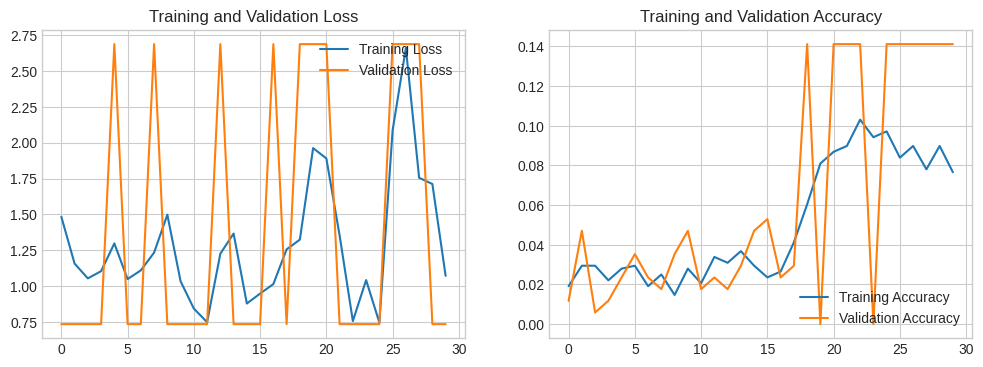

Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50


In [ ]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

#print(train_dataset)
#print(val_dataset)

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    # 訓練データセットの反復
    for batch in train_dataset:
        inputs, labels = batch
        train_step(inputs, labels, verbose)

    # 訓練の損失と精度を記録
    train_losses.append(train_loss_metric.result().numpy())
    train_accuracies.append(train_accuracy_metric.result().numpy())

    # 検証データセットの評価
    for val_batch in val_dataset:
        inputs, labels = val_batch
        val_step(inputs, labels)

    # 検証の損失と精度を記録
    val_losses.append(val_loss_metric.result().numpy())
    val_accuracies.append(val_accuracy_metric.result().numpy())

    if epoch >= 20 and (epoch + 1) % 10 == 0:  # 最初の20エポックはスキップし、10エポックごとにグラフを更新
        # プロット
        clear_output(wait=True)  # 既存のグラフをクリア
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')

        plt.subplot(1, 2, 2)
        plt.plot(train_accuracies, label='Training Accuracy')
        plt.plot(val_accuracies, label='Validation Accuracy')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Accuracy')

        plt.show()

    # メトリックのリセット
    train_loss_metric.reset_states()
    train_accuracy_metric.reset_states()
    val_loss_metric.reset_states()
    val_accuracy_metric.reset_states()

# モデルの保存 (必要に応じて)
two_tower_residual_model.save(f'{base_dir}/two_tower_residual_model.keras')

# モデルの読み出し

In [ ]:
import tensorflow as tf

# カスタムオブジェクトの登録
tf.keras.utils.get_custom_objects().update({
    'SparseFeat': SparseFeat,
    'UserModel': UserModel,
    'ItemModel': ItemModel,
    'LightSE': LightSE,
    'ResidualBlock': ResidualBlock,
    'DNN': DNN,
    'TwoTowerResidualModel': TwoTowerResidualModel
})

# モデルの読み込み
loaded_model = tf.keras.models.load_model(f'{base_dir}/two_tower_residual_model.keras')

# モデルの確認
loaded_model.summary()

In [ ]:
# ターゲットデータの埋め込みを生成（前のコードから取得）
item_inputs = {key: tf.constant(value) for key, value in processed_data.items() if key.endswith('_target')}
item_model = loaded_model.item_model
item_embeddings = item_model(item_inputs).numpy()

# 推薦関数の定義
def recommend(user_inputs, item_embeddings, k=10):
    user_model = loaded_model.user_model
    user_embedding = user_model(user_inputs).numpy()

    # 内積ベースの類似度計算
    similarities = np.dot(user_embedding, item_embeddings.T)

    # 類似度の高い順にソートして上位k個のアイテムを取得
    top_k_indices = np.argsort(similarities, axis=1)[:, -k:][:, ::-1]
    top_k_similarities = np.take_along_axis(similarities, top_k_indices, axis=1)

    return top_k_similarities, top_k_indices

# ユーザーデータをuser_modelに入力し、推薦アイテムを取得
user_inputs = {key: tf.constant(value) for key, value in processed_data.items() if key.endswith('_user')}

In [ ]:
user_inputs

In [ ]:
import time
#similarities, indices = recommend(user_inputs, item_embeddings, k=10)

# 1レコードを抜き出す
single_user_input = {key: tf.expand_dims(value[0], axis=0) for key, value in user_inputs.items()}

# 時間の計測開始
start_time = time.perf_counter()

# 推薦関数を使用して推薦アイテムを取得
similarities, indices = recommend(single_user_input, item_embeddings, k=10)

# 時間の計測終了
end_time = time.perf_counter()

# 推薦にかかった時間を計算
elapsed_time = end_time - start_time

print("推薦アイテムのインデックス:", indices)
print("推薦アイテムの類似度:", similarities)
print("推薦にかかった時間: {:.4f}秒".format(elapsed_time))

In [ ]:
# ラベルに不正な値が含まれている可能性があるので、削除
cleaning_data = data[data['rating'].isin([0, 1, 2])]
cleaning_data = cleaning_data.dropna()

# ユーザIDの重複を削除
cleaning_data = cleaning_data.drop_duplicates(subset=['user_id'])

# 不要なカラムの削除
cleaning_data = cleaning_data.drop(columns=['user_id', 'target_id', 'user_name_target', 'nickname_target',
                     'plan_target', 'account_creation_timestamp_target',
                     'user_name_user', 'nickname_user', 'plan_user',
                     'account_creation_timestamp_user'])

# 特徴量とラベルの分離
features = cleaning_data.drop(columns=['rating'])
labels = cleaning_data['rating']

# Preprocessorインスタンスの作成
preprocessor = Preprocessor(features, embedding_dims)

# データの前処理
processed_data = preprocessor.process(features)

# ターゲットデータの埋め込みを生成
item_inputs = {key: tf.constant(value) for key, value in processed_data.items() if key.endswith('_target')}
item_model = loaded_model.item_model
item_embeddings = item_model(item_inputs).numpy()

In [ ]:
# ラベルに不正な値が含まれている可能性があるので、削除
cleaning_data = data[data['rating'].isin([0, 1, 2])]
cleaning_data = cleaning_data.dropna()

# ユーザIDの重複を削除
cleaning_data = cleaning_data.drop_duplicates(subset=['user_id'])

# 不要なカラムの削除
cleaning_data = cleaning_data.drop(columns=['user_id', 'target_id', 'user_name_target', 'nickname_target',
                     'plan_target', 'account_creation_timestamp_target',
                     'user_name_user', 'nickname_user', 'plan_user',
                     'account_creation_timestamp_user'])

# 特徴量とラベルの分離
features = cleaning_data.drop(columns=['rating'])
labels = cleaning_data['rating']

# Preprocessorインスタンスの作成
preprocessor = Preprocessor(features, embedding_dims)

# データの前処理
processed_data = preprocessor.process(features)

# ターゲットデータの埋め込みを生成
item_inputs = {key: tf.constant(value) for key, value in processed_data.items() if key.endswith('_target')}
item_model = loaded_model.item_model
item_embeddings = item_model(item_inputs).numpy()

# 推薦関数の定義
def recommend(user_inputs, item_embeddings, k=10):
    user_model = loaded_model.user_model
    user_embedding = user_model(user_inputs).numpy()

    # 内積ベースの類似度計算
    similarities = np.dot(user_embedding, item_embeddings.T)

    # 類似度の高い順にソートして上位k個のアイテムを取得
    top_k_indices = np.argsort(similarities, axis=1)[:, -k:][:, ::-1]
    top_k_similarities = np.take_along_axis(similarities, top_k_indices, axis=1)

    return top_k_similarities, top_k_indices

# ユーザーデータをuser_modelに入力し、推薦アイテムを取得
user_inputs = {key: tf.constant(value) for key, value in processed_data.items() if key.endswith('_user')}

In [ ]:
# 全ユーザについての評価指標を計算する関数
def evaluate_recommendations(user_inputs, item_embeddings, labels, k=10):
    # 推薦結果を取得
    similarities, indices = recommend(user_inputs, item_embeddings, k)

    # 実際のラベルを取得
    true_labels = labels.values

    # MRR@10
    ranks = np.argsort(np.argsort(-similarities, axis=1), axis=1)
    mrr_at_10 = np.mean([1 / (ranks[i, indices[i] == true_labels[i]][0] + 1) if true_labels[i] in indices[i] else 0 for i in range(len(true_labels))])

    # Precision@10
    precision_at_10 = np.mean([1 if true_labels[i] in indices[i] else 0 for i in range(len(true_labels))])

    # MAP@10
    def average_precision(indices, true_label):
        hits = 0
        sum_precisions = 0
        for rank, index in enumerate(indices):
            if index == true_label:
                hits += 1
                sum_precisions += hits / (rank + 1)
        return sum_precisions / hits if hits > 0 else 0

    map_at_10 = np.mean([average_precision(indices[i], true_labels[i]) for i in range(len(true_labels))])

    # Recall@10
    recall_at_10 = np.mean([1 if true_labels[i] in indices[i] else 0 for i in range(len(true_labels))])

    return mrr_at_10, precision_at_10, map_at_10, recall_at_10

# 全ユーザについての評価指標を計算
mrr_at_10, precision_at_10, map_at_10, recall_at_10 = evaluate_recommendations(user_inputs, item_embeddings, labels)

# 評価指標をDataFrameに格納
evaluation_df = pd.DataFrame({
    'Metric': ['MRR@10', 'Precision@10', 'MAP@10', 'Recall@10'],
    'Value': [mrr_at_10, precision_at_10, map_at_10, recall_at_10]
})

# エクセルファイルに保存
evaluation_df.to_excel(f"{base_dir}/recommendation_evaluation.xlsx", index=False)

print("評価指標をエクセルファイルに保存しました。")

In [ ]:
import tensorflow as tf
from sklearn.metrics import roc_auc_score, log_loss
import numpy as np

def mean_reciprocal_rank(y_true, y_pred, k=10):
    order = np.argsort(y_pred)[::-1][:k]
    ranks = np.arange(1, k + 1)
    rr = np.sum((y_true[order] / ranks)) / np.sum(y_true[order])
    return rr

def precision_at_k(y_true, y_pred, k=10):
    order = np.argsort(y_pred)[::-1][:k]
    return np.mean(y_true[order])

def map_at_k(y_true, y_pred, k=10):
    order = np.argsort(y_pred)[::-1][:k]
    cumulative_precision = np.cumsum(y_true[order]) / (np.arange(1, k + 1))
    return np.mean(cumulative_precision)

def recall_at_k(y_true, y_pred, k=10):
    order = np.argsort(y_pred)[::-1][:k]
    return np.sum(y_true[order]) / np.sum(y_true)


In [ ]:
# モデルの予測を取得し、評価指標を計算
y_true = []
y_pred = []

for x, y in val_dataset:
    y_true.extend(y.numpy())
    predictions = loaded_model(x)
    y_pred.extend(predictions.numpy().flatten())

# 評価指標の計算
roc_auc = roc_auc_score(y_true, y_pred, multi_class='ovr')
logloss = log_loss(y_true, y_pred)
mrr_at_10 = mean_reciprocal_rank(y_true, y_pred, k=10)
precision_at_10 = precision_at_k(y_true, y_pred, k=10)
map_at_10 = map_at_k(y_true, y_pred, k=10)
recall_at_10 = recall_at_k(y_true, y_pred, k=10)

# 結果を表示
print(f"ROC AUC: {roc_auc}")
print(f"Log Loss: {logloss}")
print(f"MRR@10: {mrr_at_10}")
print(f"Precision@10: {precision_at_10}")
print(f"MAP@10: {map_at_10}")
print(f"Recall@10: {recall_at_10}")